In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector, Operator

import matplotlib.pyplot as plt

import numpy as np

# Grover's algorithm

Input:

$| s \rangle$: initial state

$| t \rangle$: target state

Adjust phases, so that

$\sqrt{\lambda} := \langle s | t\rangle \in \mathbb{R}_+$.

Then $\lambda \in (0, 1)$ is the probability of measuring $| t \rangle$ in state $| s \rangle$. Write

$$
| s^\perp \rangle = \frac{| t \rangle - \sqrt{\lambda} | s \rangle}{\sqrt{1 - \lambda}}.
$$

Then $\langle s^\perp | s^\perp \rangle = 1$ and

$$
| t^\perp \rangle := \sqrt{1 - \lambda} | s \rangle - \sqrt{\lambda} | s^\perp \rangle.
$$

Assume we have $S$ and $U$, such that

$S | s \rangle = - | s \rangle$ and $S | s^\perp \rangle = | s^\perp \rangle$.

$U | t \rangle = - | t \rangle$ and $U | t^\perp \rangle = | s^\perp \rangle$.

Remark: Their actions on $\mathrm{span} \left( \left\{ | s \rangle, | t \rangle \right\} \right)^\perp$ is irrelevant.

NOTE: $G := - S \circ U$ is a rotation by $\Theta := 2 \arcsin \left( \sqrt{\lambda} \right)$ in the $\mathrm{span} \left( \left\{ | s \rangle, | t \rangle \right\} \right)$ plane (positively oriented).

Thm (Grover '96):

\begin{equation}
    \mathbb{P} (t | k) := \left| \langle t | G^k | s \rangle \right|^2 = \sin^2 \left( \left(k + \tfrac{1}{2} \right) \Theta \right).
\end{equation}

Maximum success probability at $K := \lfloor \tfrac{\pi}{2 \Theta} - \tfrac{1}{2} \rceil$.

## Example: Solving Pseudo-boolean equations.

Let $F: \mathbb{F}_2^2 \rightarrow \mathbb{Z}$ be defined as

\begin{equation}
    F(x_0, x_1) = 2 x_0 + x_1.
\end{equation}

Our goal is the solve the equation
\begin{equation}
    F(x_0, x_1) = 2,
\end{equation}

using Grover's algorithm.

## Ingredients for the marker oracle

Check that the following circuit achieves $| x \rangle_2 \rangle | 0 \rangle_2 \mapsto | x \rangle_2 | F(x) \rangle$.

(More generally, it s action is given by $| x \rangle_2 \rangle | y \rangle_2 \mapsto | x \rangle_2 | y + F(x) \: \mod \: 2^2 \rangle$)

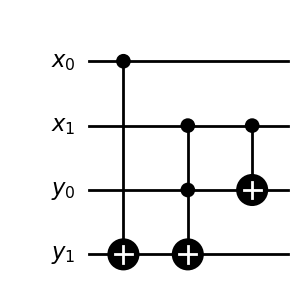

In [2]:
quantum_register = QuantumRegister(size=2, name="x")
ancilla_register = AncillaRegister(size=2, name="y")

F_adder = QuantumCircuit(quantum_register, ancilla_register, name="F(x) adder")

F_adder.cx(quantum_register[0], ancilla_register[1])
F_adder.ccx(quantum_register[1], ancilla_register[0], ancilla_register[1])
F_adder.cx(quantum_register[1], ancilla_register[0])

F_adder.draw(output="mpl", style="bw")

Let us create the inverse to $F_{adder}$!

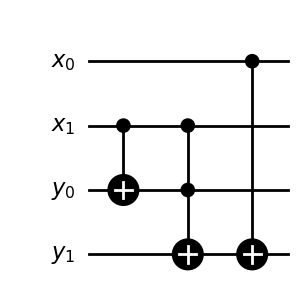

In [3]:
quantum_register = QuantumRegister(size=2, name="x")
ancilla_register = AncillaRegister(size=2, name="y")

F_subtractor = QuantumCircuit(quantum_register, ancilla_register, name="F(x) subtractor")

### write the rest of the code below

F_subtractor.cx(quantum_register[1], ancilla_register[0])
F_subtractor.ccx(quantum_register[1], ancilla_register[0], ancilla_register[1])
F_subtractor.cx(quantum_register[0], ancilla_register[1])

###

F_subtractor.draw(output="mpl", style="bw")

### There is also a quicker way! 'F_subtractor' is the same as 'F_adder.inverse()'

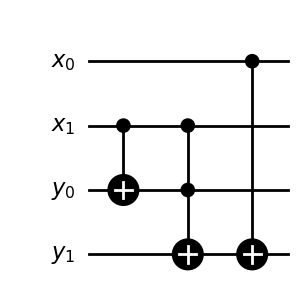

In [4]:
F_adder.inverse().draw(output="mpl", style="bw")

In [5]:
A = F_adder.to_gate()
Adg = F_subtractor.to_gate()

Let $| t \rangle = | x_0 x_1 \rangle$ be such that $F(x_0, x_1) = 2$.

## Use $A$ and $A^\dagger$ (without soliving for $(x_0, x_1) \in \mathbb{F}_2^2$) to create the marker oracle, $U$.

Note: 'circuit.compose(A, inplace=True)' applies the gate 'A' to 'circuit'

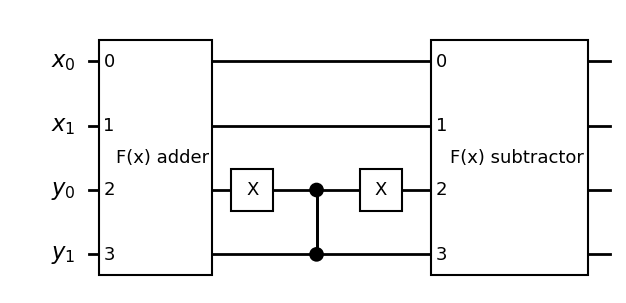

In [6]:
quantum_register = QuantumRegister(size=2, name="x")
ancilla_register = AncillaRegister(size=2, name="y")

marker_circuit = QuantumCircuit(quantum_register, ancilla_register, name="marker")

### write the rest of the code below

marker_circuit.compose(A, inplace=True)

marker_circuit.x(ancilla_register[0])
marker_circuit.cz(ancilla_register[0], ancilla_register[1])
marker_circuit.x(ancilla_register[0])

marker_circuit.compose(Adg, inplace=True)

###

marker_circuit.draw(output="mpl", style="bw")

Can you simplify the the above circuit?

## State preparation.

Let $| s \rangle := \tfrac{1}{2} \left( | 00 \rangle + | 10 \rangle + | 01 \rangle + | 11 \rangle \right)$.

Let us create a circuit, $\mathrm{Prep}$, that creates this state, that is

$\mathrm{Prep} | 0 \rangle = | s \rangle$.

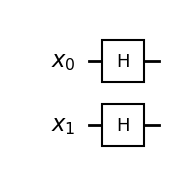

In [7]:
quantum_register = QuantumRegister(size=2, name="x")

state_preparation_circuit = QuantumCircuit(quantum_register, name="State preparation")

state_preparation_circuit.h(quantum_register)

state_preparation_circuit.draw(output="mpl", style="bw")

In [8]:
Prep = state_preparation_circuit.to_gate()

## Let's create the "diffuser" circtuit, $S$.

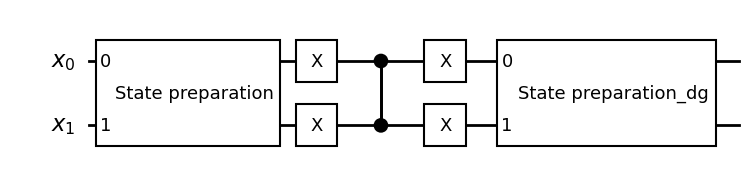

In [9]:
quantum_register = QuantumRegister(size=2, name="x")

diffuser_circuit = QuantumCircuit(quantum_register, name="diffuser")

### write the rest of the code below

diffuser_circuit.compose(Prep, inplace=True)

diffuser_circuit.x(quantum_register)
diffuser_circuit.cz(quantum_register[0], quantum_register[1])
diffuser_circuit.x(quantum_register)

diffuser_circuit.compose(Prep.inverse(), inplace=True)

###

diffuser_circuit.draw(output="mpl", style="bw")

In [10]:
U = marker_circuit.to_gate()
D = diffuser_circuit.to_gate()

What is the number of iteration, $K$, that you will need?

In [11]:
n = 2
N = 2**n

### K = ? (write it as a function of N)

K = int(np.rint(np.pi / (4 * np.arcsin(1 / np.sqrt(N))) - 1/2))
K

1

# Full Grover circuit

Construct the full Grover search circuit and check the probabilities as the end.

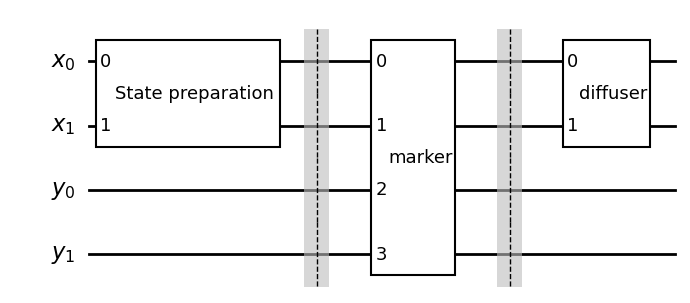

In [12]:
quantum_register = QuantumRegister(size=2, name="x")
ancilla_register = AncillaRegister(size=2, name="y")

grover_circuit = QuantumCircuit(quantum_register, ancilla_register, name="Grover circuit")

### write the rest of the code below

grover_circuit.compose(Prep, qubits=quantum_register[:], inplace=True)

for _ in range(1):
    grover_circuit.barrier()
    grover_circuit.compose(U, inplace=True)
    grover_circuit.barrier()
    grover_circuit.compose(D, qubits=quantum_register[:], inplace=True)

###

grover_circuit.draw(output="mpl", style="bw")

In [13]:
psi = Statevector(grover_circuit)
psi.probabilities()

array([5.57706021e-34, 1.00000000e+00, 1.59557706e-68, 9.07105347e-35,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

Numerical noise makes it seem messy, so let's simplify:

In [14]:
np.round(psi.probabilities(), 4)

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Maximum probability at $\mathrm{index} = 1$, which is equivalent to $(x_0, x_1) = (1, 0)$, and $F (1, 0) = 2 \cdot 1 + 0 = 2$.

# Change in the probability density over the iterations

In [15]:
n = 7
N = 2**n
K = int(np.rint(np.pi / (4 * np.arcsin(1 / np.sqrt(N))) - 1/2))
Theta = 2 * np.arcsin(1/np.sqrt(N))
K, Theta

(8, np.float64(0.1770076862880309))

In [16]:
iterations = np.arange(1, 4 * K + 1) # let us allow under-, and overcooking
P_success_over_time = np.square(np.sin((iterations + 1/2) * Theta))

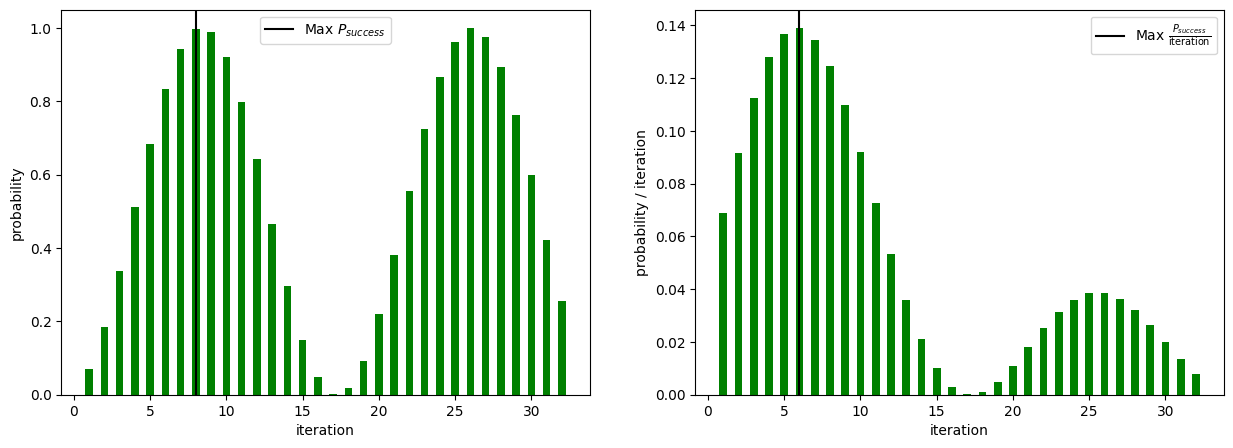

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15, 5))

axs[0].bar(iterations,
           P_success_over_time,
           width=0.5,
           color="green")
axs[0].set(xlabel=f"iteration",
           ylabel=f"probability")
axs[0].axvline(x = K,
               linewidth=1.5,
               color="black",
               label=r"Max $P_{success}$")

axs[0].legend(loc='best')

axs[1].bar(iterations,
           P_success_over_time / iterations,
           width=0.5,
           color="green")
axs[1].set(xlabel=f"iteration",
           ylabel=f"probability / iteration")
axs[1].axvline(x = iterations[np.argmax(P_success_over_time / iterations)],
               linewidth=1.5,
               color="black",
               label=r"Max $\frac{P_{success}}{\mathrm{iteration}}$")

axs[1].legend(loc='best')

plt.show()

NOTE: if you are optimizing for expected amounts of overall resources, then running $k = 6 (< 8 = K)$ iterations yields better results!